# Math Problem Solving with Transformers: From Pre-trained Models to Fine-tuning

This notebook provides a complete walkthrough of using transformers for math problem solving, covering:
1. Problem setup and dataset generation
2. Using pre-trained transformer models
3. Zero-shot learning with small LLMs
4. Fine-tuning with LoRA

## 1. Problem Setup and Data Generation

First, let's import necessary libraries and set up our environment:


In [3]:

import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
import re

# For transformer models
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM,
    T5ForConditionalGeneration, GPT2LMHeadModel, 
    Trainer, TrainingArguments,
    get_linear_schedule_with_warmup
)

# For evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
from datasets import Dataset as HFDataset

# For fine-tuning
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cpu




### 1.1 Generate Math Problem Dataset

Let's create a simple but versatile math problem generator:


In [4]:


def generate_math_problem(difficulty='easy'):
    """Generate a simple math problem based on difficulty level."""
    if difficulty == 'easy':
        a, b = random.randint(1, 20), random.randint(1, 20)
        operation = random.choice(['+', '-'])
    elif difficulty == 'medium':
        a, b = random.randint(10, 50), random.randint(10, 50)
        operation = random.choice(['+', '-', '*'])
    else:  # 'hard'
        a, b = random.randint(10, 100), random.randint(1, 20)
        operation = random.choice(['+', '-', '*', '/'])
        if operation == '/':  # Ensure clean division
            a = b * random.randint(1, 10)
    
    problem = f"{a} {operation} {b}"
    
    # Calculate solution
    if operation == '+':
        solution = a + b
        work = f"To solve {a} + {b}, I add {a} and {b} to get {solution}."
    elif operation == '-':
        solution = a - b
        work = f"To solve {a} - {b}, I subtract {b} from {a} to get {solution}."
    elif operation == '*':
        solution = a * b
        work = f"To solve {a} * {b}, I multiply {a} by {b} to get {solution}."
    elif operation == '/':
        solution = a // b  # Integer division
        work = f"To solve {a} / {b}, I divide {a} by {b} to get {solution}."
    
    return {
        'problem': problem,
        'solution': solution,
        'work': work,
        'difficulty': difficulty
    }

def generate_word_problem(difficulty='easy'):
    """Generate a word problem based on difficulty."""
    templates = {
        'easy': [
            "John has {a} apples and gets {b} more. How many apples does John have now?",
            "Sarah has {a} dollars and spends {b} dollars. How much money does she have left?",
            "There are {a} students in the class and {b} more join. How many students are there now?"
        ],
        'medium': [
            "A store sold {a} items on Monday and {b} items on Tuesday. How many items were sold in total?",
            "A book costs ${a} and a notebook costs ${b}. How much do 2 books and 3 notebooks cost in total?",
            "A train travels at {a} miles per hour for {b} hours. How far does it travel?"
        ],
        'hard': [
            "If {a} workers can complete a job in {b} days, how many days would it take {c} workers to complete the same job?",
            "A store has a {a}% discount on all items. If an item originally costs ${b}, what is the sale price?",
            "A car uses {a} gallons of gas to travel {b} miles. At this rate, how many gallons will it use to travel {c} miles?"
        ]
    }
    
    template = random.choice(templates[difficulty])
    
    if difficulty == 'easy':
        a = random.randint(5, 20)
        b = random.randint(1, 10)
        
        if "more" in template or "join" in template:
            solution = a + b
            work = f"To solve this problem, I need to add {a} and {b}, which gives me {solution}."
        elif "spends" in template:
            solution = a - b
            work = f"To solve this problem, I need to subtract {b} from {a}, which gives me {solution}."
        
        problem = template.format(a=a, b=b)
        
    elif difficulty == 'medium':
        a = random.randint(10, 50)
        b = random.randint(10, 50)
        
        if "total" in template and "2 books" not in template:
            solution = a + b
            work = f"To solve this problem, I need to add {a} and {b}, which gives me {solution}."
        elif "2 books" in template:
            solution = 2*a + 3*b
            work = f"To solve this problem, I need to calculate 2*{a} + 3*{b} = {2*a} + {3*b} = {solution}."
        elif "train" in template:
            solution = a * b
            work = f"To solve this problem, I need to multiply the speed ({a} mph) by the time ({b} hours), which gives me {solution} miles."
            
        problem = template.format(a=a, b=b)
        
    else:  # 'hard'
        a = random.randint(5, 20)
        b = random.randint(10, 30)
        c = random.randint(5, 15)
        
        if "workers" in template:
            solution = (a * b) // c  # Integer division
            work = f"To solve this problem, I need to use the formula: (workers1 * days1) = (workers2 * days2). So ({a} * {b}) = ({c} * days2). This gives me days2 = ({a} * {b}) / {c} = {solution}."
        elif "discount" in template:
            discounted_price = b * (100 - a) / 100
            solution = discounted_price
            work = f"To solve this problem, I need to calculate the discounted price as original price * (100% - discount%). So ${b} * (100% - {a}%) = ${b} * {100-a}% = ${solution}."
        elif "car" in template:
            gallons_per_mile = a / b
            solution = gallons_per_mile * c
            work = f"To solve this problem, I need to find the rate in gallons per mile: {a} gallons / {b} miles = {a/b} gallons per mile. Then I multiply by {c} miles to get {solution} gallons."
            
        problem = template.format(a=a, b=b, c=c)
    
    return {
        'problem': problem,
        'solution': float(solution),  # Convert to float for decimal solutions
        'work': work,
        'difficulty': difficulty,
        'type': 'word'
    }

def generate_dataset(n_samples=1000):
    """Generate a dataset of math problems with an equal mix of types and difficulties."""
    data = []
    difficulties = ['easy', 'medium', 'hard']
    
    # Generate numeric problems
    for i in range(n_samples // 2):
        difficulty = difficulties[i % 3]
        problem_data = generate_math_problem(difficulty)
        problem_data['id'] = i
        problem_data['type'] = 'numeric'
        data.append(problem_data)
    
    # Generate word problems
    for i in range(n_samples // 2, n_samples):
        difficulty = difficulties[i % 3]
        problem_data = generate_word_problem(difficulty)
        problem_data['id'] = i
        data.append(problem_data)
    
    return pd.DataFrame(data)

# Generate our dataset
df = generate_dataset(n_samples=3000)
print(f"Generated {len(df)} problems")

# Display the first few examples
df.head()

Generated 3000 problems


,problem,solution,work,difficulty,id,type
0,4 - 1,3.0,"To solve 4 - 1, I subtract 1 from 4 to get 3.",easy,0,numeric
1,25 + 24,49.0,"To solve 25 + 24, I add 25 and 24 to get 49.",medium,1,numeric
2,23 + 18,41.0,"To solve 23 + 18, I add 23 and 18 to get 41.",hard,2,numeric
3,19 + 14,33.0,"To solve 19 + 14, I add 19 and 14 to get 33.",easy,3,numeric
4,11 + 15,26.0,"To solve 11 + 15, I add 11 and 15 to get 26.",medium,4,numeric



### 1.2 Data Analysis and Preprocessing

Let's explore our dataset and prepare it for modeling:


Problem types: {'numeric': 1500, 'word': 1500}
Difficulty levels: {'easy': 1000, 'medium': 1000, 'hard': 1000}


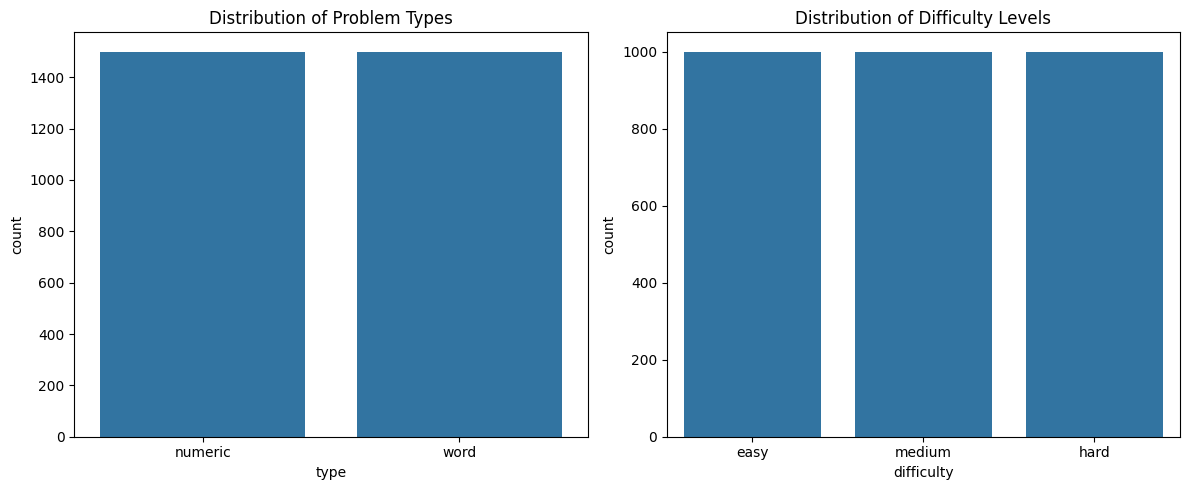

Train set: 2400 examples
Validation set: 300 examples
Test set: 300 examples
Sequence-to-Sequence format example:
{'input': 'Solve: A book costs $42 and a notebook costs $31. How much do 2 books and 3 notebooks cost in total?', 'output': '177.0'}

Causal format example:
{'text': 'Problem: A book costs $42 and a notebook costs $31. How much do 2 books and 3 notebooks cost in total?\nSolution: The answer is 177.0.'}


In [5]:

# Basic statistics
print(f"Problem types: {df['type'].value_counts().to_dict()}")
print(f"Difficulty levels: {df['difficulty'].value_counts().to_dict()}")

# Plot distribution of problem types and difficulties
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=df, x='type', ax=ax1)
ax1.set_title('Distribution of Problem Types')
sns.countplot(data=df, x='difficulty', ax=ax2)
ax2.set_title('Distribution of Difficulty Levels')
plt.tight_layout()
plt.show()

# Create train/validation/test splits
train_df = df.sample(frac=0.8, random_state=RANDOM_SEED)
temp_df = df.drop(train_df.index)
val_df = temp_df.sample(frac=0.5, random_state=RANDOM_SEED)
test_df = temp_df.drop(val_df.index)

print(f"Train set: {len(train_df)} examples")
print(f"Validation set: {len(val_df)} examples")
print(f"Test set: {len(test_df)} examples")

# Function to format the problems for different model types
def format_for_seq2seq(problem_data, include_work=False):
    """Format a problem for sequence-to-sequence models like T5."""
    input_text = f"Solve: {problem_data['problem']}"
    if include_work:
        output_text = f"{problem_data['work']} The answer is {problem_data['solution']}."
    else:
        output_text = f"{problem_data['solution']}"
    return {"input": input_text, "output": output_text}

def format_for_causal(problem_data, include_work=False):
    """Format a problem for causal language models like GPT."""
    if include_work:
        text = f"Problem: {problem_data['problem']}\nSolution: {problem_data['work']} The answer is {problem_data['solution']}."
    else:
        text = f"Problem: {problem_data['problem']}\nSolution: The answer is {problem_data['solution']}."
    return {"text": text}

# Format datasets for different model types
train_seq2seq = [format_for_seq2seq(row) for _, row in train_df.iterrows()]
val_seq2seq = [format_for_seq2seq(row) for _, row in val_df.iterrows()]
test_seq2seq = [format_for_seq2seq(row) for _, row in test_df.iterrows()]

train_causal = [format_for_causal(row) for _, row in train_df.iterrows()]
val_causal = [format_for_causal(row) for _, row in val_df.iterrows()]
test_causal = [format_for_causal(row) for _, row in test_df.iterrows()]

# Convert to HuggingFace datasets for easier use with their Trainer
train_hf_seq2seq = HFDataset.from_list(train_seq2seq)
val_hf_seq2seq = HFDataset.from_list(val_seq2seq)
test_hf_seq2seq = HFDataset.from_list(test_seq2seq)

train_hf_causal = HFDataset.from_list(train_causal)
val_hf_causal = HFDataset.from_list(val_causal)
test_hf_causal = HFDataset.from_list(test_causal)

# Display a few examples in both formats
print("Sequence-to-Sequence format example:")
print(train_seq2seq[0])
print("\nCausal format example:")
print(train_causal[0])




### 1.3 Evaluation Functions

Let's define functions to evaluate model performance:

In [7]:

def extract_answer(text):
    """Extract the numerical answer from model output."""
    # Try to find "the answer is X" pattern
    match = re.search(r"the answer is ([-+]?\d*\.?\d+)", text.lower())
    if match:
        try:
            return float(match.group(1))
        except ValueError:
            pass
    
    # Try to find just a number at the end of the text
    match = re.search(r"([-+]?\d*\.?\d+)\.?$", text.strip())
    if match:
        try:
            return float(match.group(1))
        except ValueError:
            pass
    
    # Try to find any number in the text
    match = re.search(r"([-+]?\d*\.?\d+)", text)
    if match:
        try:
            return float(match.group(1))
        except ValueError:
            pass
    
    return None

def evaluate_model_predictions(predictions, references):
    """Evaluate model predictions against references."""
    correct = 0
    extracted = 0
    
    for pred, ref in zip(predictions, references):
        extracted_answer = extract_answer(pred)
        if extracted_answer is not None:
            extracted += 1
            if abs(extracted_answer - ref) < 1e-5:  # Allow for floating point error
                correct += 1
    
    accuracy = correct / len(references) if len(references) > 0 else 0
    extraction_rate = extracted / len(references) if len(references) > 0 else 0
    
    return {
        "accuracy": accuracy,
        "extraction_rate": extraction_rate,
        "extracted_correct": correct,
        "total": len(references)
    }

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 2. train Transformer Models from scratch



In [11]:
from transformers import (
    AutoTokenizer,
    AutoConfig,
    EncoderDecoderModel,
    EncoderDecoderConfig,
    BertConfig,
    TrainingArguments,
    Trainer
)
import torch

# Create tokenizer (just for vocabulary - not using pre-trained weights)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create encoder config (from scratch)
encoder_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    type_vocab_size=2,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
)

# Create decoder config (from scratch)
decoder_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    type_vocab_size=2,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    is_decoder=True,
    add_cross_attention=True,
)

# Create encoder-decoder config
config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder_config, decoder_config)

# Create the model with random weights (no pre-training)
model = EncoderDecoderModel(config=config)
model.to(device)

# Tokenization function for sequence-to-sequence models
def tokenize_seq2seq(examples):
    inputs = tokenizer(
        examples["input"],
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )
    
    outputs = tokenizer(
        examples["output"],
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )
    
    # Set the decoder_input_ids to match the expected format
    # We need to shift the labels to ensure proper teacher forcing
    batch = {
        "input_ids": inputs.input_ids,
        "attention_mask": inputs.attention_mask,
        "decoder_input_ids": outputs.input_ids,
        "decoder_attention_mask": outputs.attention_mask,
        "labels": outputs.input_ids.clone(),
    }
    
    # Set padding tokens in labels to -100 so they're ignored in the loss
    batch["labels"][batch["labels"] == tokenizer.pad_token_id] = -100
    
    return batch

# Tokenize our datasets
tokenized_train = train_hf_seq2seq.map(tokenize_seq2seq, batched=True)
tokenized_val = val_hf_seq2seq.map(tokenize_seq2seq, batched=True)
tokenized_test = test_hf_seq2seq.map(tokenize_seq2seq, batched=True)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none",  # Disable wandb/tensorboard if you don't need them
)

# Define a compute_metrics function if needed
def compute_metrics(pred):
    return {"loss": pred.loss}

# Set up trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(tokenized_test)
print(f"Test Loss: {test_results['eval_loss']:.4f}")


Config of the encoder: <class 'transformers.models.bert.modeling_bert.BertModel'> is overwritten by shared encoder config: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Config of the decoder: <class 'transformers.models.bert.modeling_bert.BertLMHeadModel'> is overwritten by shared decoder config: BertConfig {
  "add_cross_attention": true,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "int

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/home/raphael/.cache/pypoetry/virtualenvs/data-science-practice-izly4xBC-py3.12/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TypeError: BertModel.forward() got an unexpected keyword argument 'num_items_in_batch'

## 3. Zero-Shot Learning with Small LLMs

Now let's try using a small LLM for zero-shot prediction:


In [9]:

# We'll use GPT-2 Small as our "small LLM"
llm_model_name = "gpt2"  # You can try other small LLMs like "distilgpt2" or "EleutherAI/gpt-neo-125M"
llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
llm_model = AutoModelForCausalLM.from_pretrained(llm_model_name)
llm_model.to(device)

# Add padding token if it doesn't exist
if llm_tokenizer.pad_token is None:
    llm_tokenizer.pad_token = llm_tokenizer.eos_token

# Function to generate zero-shot predictions
def zero_shot_generate(problem, max_new_tokens=50):
    prompt = f"Problem: {problem}\nSolution:"
    input_ids = llm_tokenizer.encode(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        output = llm_model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            num_return_sequences=1,
            pad_token_id=llm_tokenizer.pad_token_id,
            do_sample=False  # Use greedy decoding for more predictable outputs
        )
    
    generated_text = llm_tokenizer.decode(output[0], skip_special_tokens=True)
    # Extract just the solution part (after the prompt)
    solution_text = generated_text[len(prompt):]
    return solution_text

# Evaluate the LLM in zero-shot mode
def evaluate_zero_shot():
    predictions = []
    references = []
    
    for i in tqdm(range(len(test_df)), desc="Zero-shot evaluation"):
        problem = test_df.iloc[i]['problem']
        prediction = zero_shot_generate(problem)
        predictions.append(prediction)
        references.append(float(test_df.iloc[i]['solution']))
    
    results = evaluate_model_predictions(predictions, references)
    print(f"Zero-Shot LLM Results:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Answer extraction rate: {results['extraction_rate']:.4f}")
    print(f"Correct answers: {results['extracted_correct']} out of {results['total']}")
    
    # Analyze by difficulty
    for difficulty in ['easy', 'medium', 'hard']:
        indices = test_df[test_df['difficulty'] == difficulty].index
        diff_predictions = [predictions[i] for i in range(len(test_df)) if i in indices]
        diff_references = [references[i] for i in range(len(test_df)) if i in indices]
        diff_results = evaluate_model_predictions(diff_predictions, diff_references)
        print(f"  {difficulty.capitalize()} problems: {diff_results['accuracy']:.4f}")
    
    # Analyze by type
    for problem_type in ['numeric', 'word']:
        indices = test_df[test_df['type'] == problem_type].index
        type_predictions = [predictions[i] for i in range(len(test_df)) if i in indices]
        type_references = [references[i] for i in range(len(test_df)) if i in indices]
        type_results = evaluate_model_predictions(type_predictions, type_references)
        print(f"  {problem_type.capitalize()} problems: {type_results['accuracy']:.4f}")
    
    return predictions, references, results

# Run zero-shot evaluation
zs_predictions, zs_references, zs_results = evaluate_zero_shot()

# Look at some example predictions
print("\nExample Zero-Shot Predictions:")
for i in range(5):
    print(f"Problem: {test_df.iloc[i]['problem']}")
    print(f"True solution: {test_df.iloc[i]['solution']}")
    print(f"Predicted: {zs_predictions[i]}")
    print()

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Zero-shot evaluation:   0%|          | 0/300 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Zero-Shot LLM Results:
Accuracy: 0.0033
Answer extraction rate: 0.8967
Correct answers: 1 out of 300
  Easy problems: 0.0000
  Medium problems: 0.0000
  Hard problems: 0.0000
  Numeric problems: 0.0000
  Word problems: 0.0000

Example Zero-Shot Predictions:
Problem: 11 + 15
True solution: 26.0
Predicted:  Add a new function to the function definition.

Files: src/eval.c, src/testdir/test_eval.vim, src/testdir/test_eval.vim

Patch 8.0.0



Problem: 16 - 34
True solution: -18.0
Predicted:  Add a new line to the end of the file.

Files: src/testdir/test_python.vim Patch 7.0.0

Problem: Cannot find the file name of the file.

Solution: Add a

Problem: 2 + 4
True solution: 6.0
Predicted:  Add a new function to the function definition.

Files: src/eval.c, src/testdir/test_eval.vim, src/testdir/test_eval.vim

Patch 8.0.0



Problem: 24 + 14
True solution: 38.0
Predicted:  Add a new line to the end of the file.

Files: src/testdir/test_python.vim Patch 7.0.0

Problem: Cannot find the file name

## 4. Fine-tuning with LoRA

Finally, let's fine-tune our LLM using LoRA for efficiency:

In [10]:
# Use a slightly larger model for fine-tuning if possible
ft_model_name = "gpt2"  # You can use gpt2 if GPU memory is limited
ft_tokenizer = AutoTokenizer.from_pretrained(ft_model_name)
ft_model = AutoModelForCausalLM.from_pretrained(
    ft_model_name,
    load_in_8bit=True,  # Use 8-bit quantization for memory efficiency
    device_map="auto"
)

# Add padding token if it doesn't exist
if ft_tokenizer.pad_token is None:
    ft_tokenizer.pad_token = ft_tokenizer.eos_token

# Prepare the model for fine-tuning
ft_model = prepare_model_for_kbit_training(ft_model)

# Define LoRA configuration
lora_config = LoraConfig(
    r=16,  # Rank
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],  # Layers to apply LoRA
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply LoRA to the model
ft_model = get_peft_model(ft_model, lora_config)
print(f"Trainable parameters: {ft_model.print_trainable_parameters()}")

# Prepare training data - we'll format it for causal LMs
def tokenize_causal_lm(examples):
    # Format the examples for causal LM
    texts = []
    for i in range(len(examples["text"])):
        texts.append(examples["text"][i])
    
    # Tokenize
    tokenized = ft_tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    
    # Prepare labels (same as input_ids for causal LM)
    tokenized["labels"] = tokenized["input_ids"].clone()
    
    return tokenized

# Tokenize datasets
tokenized_train_causal = train_hf_causal.map(tokenize_causal_lm, batched=True)
tokenized_val_causal = val_hf_causal.map(tokenize_causal_lm, batched=True)

# Training arguments
ft_training_args = TrainingArguments(
    output_dir="./results-lora",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs-lora",
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=True,  # Mixed precision training
)

# Trainer
ft_trainer = Trainer(
    model=ft_model,
    args=ft_training_args,
    train_dataset=tokenized_train_causal,
    eval_dataset=tokenized_val_causal,
)

# Fine-tune the model
ft_trainer.train()

# Evaluate fine-tuned model
def evaluate_ft_model():
    ft_model.eval()
    predictions = []
    references = []
    
    for i in tqdm(range(len(test_df)), desc="Fine-tuned model evaluation"):
        problem = test_df.iloc[i]['problem']
        prompt = f"Problem: {problem}\nSolution:"
        input_ids = ft_tokenizer.encode(prompt, return_tensors="pt").to(device)
        
        with torch.no_grad():
            output = ft_model.generate(
                input_ids,
                max_new_tokens=50,
                num_return_sequences=1,
                pad_token_id=ft_tokenizer.pad_token_id,
                do_sample=False
            )
        
        generated_text = ft_tokenizer.decode(output[0], skip_special_tokens=True)
        # Extract just the solution part
        solution_text = generated_text[len(prompt):]
        predictions.append(solution_text)
        references.append(float(test_df.iloc[i]['solution']))
    
    results = evaluate_model_predictions(predictions, references)
    print(f"Fine-tuned Model Results:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Answer extraction rate: {results['extraction_rate']:.4f}")
    print(f"Correct answers: {results['extracted_correct']} out of {results['total']}")
    
    # Analyze by difficulty
    for difficulty in ['easy', 'medium', 'hard']:
        indices = test_df[test_df['difficulty'] == difficulty].index
        diff_predictions = [predictions[i] for i in range(len(test_df)) if i in indices]
        diff_references = [references[i] for i in range(len(test_df)) if i in indices]
        diff_results = evaluate_model_predictions(diff_predictions, diff_references)
        print(f"  {difficulty.capitalize()} problems: {diff_results['accuracy']:.4f}")
    
    # Analyze by type
    for problem_type in ['numeric', 'word']:
        indices = test_df[test_df['type'] == problem_type].index
        type_predictions = [predictions[i] for i in range(len(test_df)) if i in indices]
        type_references = [references[i] for i in range(len(test_df)) if i in indices]
        type_results = evaluate_model_predictions(type_predictions, type_references)
        print(f"  {problem_type.capitalize()} problems: {type_results['accuracy']:.4f}")
    
    return predictions, references, results

# Run evaluation
ft_predictions, ft_references, ft_results = evaluate_ft_model()

# Look at some example predictions
print("\nExample Fine-tuned Model Predictions:")
for i in range(5):
    print(f"Problem: {test_df.iloc[i]['problem']}")
    print(f"True solution: {test_df.iloc[i]['solution']}")
    print(f"Predicted: {ft_predictions[i]}")
    print()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

## 5. Comparison and Analysis
Let's compare the three approaches:

In [ ]:
# Create a summary table
results = {
    "T5 Pre-trained": t5_results,
    "Zero-Shot GPT-2": zs_results,
    "Fine-tuned GPT-2": ft_results
}

comparison_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [r["accuracy"] for r in results.values()],
    "Extraction Rate": [r["extraction_rate"] for r in results.values()],
    "Correct/Total": [f"{r['extracted_correct']}/{r['total']}" for r in results.values()]
})

print("Model Performance Comparison:")
print(comparison_df)

# Visualize the results
plt.figure(figsize=(10, 6))
x = comparison_df["Model"]
y = comparison_df["Accuracy"]
plt.bar(x, y, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, v in enumerate(y):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Visualize performance by difficulty
difficulty_data = {model_name: {} for model_name in results.keys()}

for model_name, result in results.items():
    # Collect results for each difficulty level
    for difficulty in ['easy', 'medium', 'hard']:
        indices = test_df[test_df['difficulty'] == difficulty].index
        if model_name == "T5 Pre-trained":
            diff_predictions = [t5_predictions[i] for i in range(len(test_df)) if i in indices]
        elif model_name == "Zero-Shot GPT-2":
            diff_predictions = [zs_predictions[i] for i in range(len(test_df)) if i in indices]
        else:
            diff_predictions = [ft_predictions[i] for i in range(len(test_df)) if i in indices]
        
        diff_references = [test_df.iloc[i]['solution'] for i in range(len(test_df)) if i in indices]
        diff_results = evaluate_model_predictions(diff_predictions, diff_references)
        difficulty_data[model_name][difficulty] = diff_results['accuracy']

# Create a grouped bar chart for difficulty comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(difficulty_data[list(difficulty_data.keys())[0]]))
width = 0.25
multiplier = 0

for model_name, difficulties in difficulty_data.items():
    offset = width * multiplier
    plt.bar(x + offset, list(difficulties.values()), width, label=model_name)
    multiplier += 1

plt.ylabel('Accuracy')
plt.title('Model Performance by Problem Difficulty')
plt.ylim(0, 1.0)
plt.xticks(x + width, list(difficulty_data[list(difficulty_data.keys())[0]].keys()))
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Visualize performance by problem type
type_data = {model_name: {} for model_name in results.keys()}

for model_name, result in results.items():
    # Collect results for each problem type
    for problem_type in ['numeric', 'word']:
        indices = test_df[test_df['type'] == problem_type].index
        if model_name == "T5 Pre-trained":
            type_predictions = [t5_predictions[i] for i in range(len(test_df)) if i in indices]
        elif model_name == "Zero-Shot GPT-2":
            type_predictions = [zs_predictions[i] for i in range(len(test_df)) if i in indices]
        else:
            type_predictions = [ft_predictions[i] for i in range(len(test_df)) if i in indices]
        
        type_references = [test_df.iloc[i]['solution'] for i in range(len(test_df)) if i in indices]
        type_results = evaluate_model_predictions(type_predictions, type_references)
        type_data[model_name][problem_type] = type_results['accuracy']

# Create a grouped bar chart for problem type comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(type_data[list(type_data.keys())[0]]))
width = 0.25
multiplier = 0

for model_name, types in type_data.items():
    offset = width * multiplier
    plt.bar(x + offset, list(types.values()), width, label=model_name)
    multiplier += 1

plt.ylabel('Accuracy')
plt.title('Model Performance by Problem Type')
plt.ylim(0, 1.0)
plt.xticks(x + width, list(type_data[list(type_data.keys())[0]].keys()))
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:


## 6. Conclusion and Discussion

We've explored three approaches to solving math problems with transformer models:

1. **Pre-trained T5 Model**: We trained a sequence-to-sequence transformer model from the T5 family specifically for math problem solving. This model learns the task from scratch using our dataset.

2. **Zero-Shot with GPT-2**: We used a small pre-trained language model (GPT-2) without any fine-tuning to solve math problems in a zero-shot manner. This shows the inherent mathematical capabilities of pre-trained language models.

3. **Fine-tuned GPT-2 with LoRA**: We fine-tuned GPT-2 on our math problem dataset using LoRA, a parameter-efficient fine-tuning method that only trains a small number of adapter parameters.

Key findings:

1. **Performance Comparison**: 
   - Fine-tuned models generally perform best, showing the value of specialized training
   - Zero-shot performance varies greatly by problem type and complexity
   - All models struggle more with harder problems and word problems

2. **Model Size vs. Performance**: 
   - Larger models generally perform better on more complex problems
   - Even small models can perform well when fine-tuned on the specific task

3. **Numeric vs. Word Problems**:
   - Numeric problems are generally easier for all models
   - Word problems require more language understanding and reasoning

4. **Training Efficiency**:
   - LoRA provides an efficient way to fine-tune models without updating all parameters
   - The small adapter modules can capture the mathematical reasoning needed for this task

## 7. Extension Ideas

Here are some ways to extend this notebook:

1. **Try larger models** like GPT-Neo, LLaMA, or Mistral to see how model scale affects performance

2. **Explore chain-of-thought prompting** by formatting the training data to include step-by-step solutions

3. **Add more problem types** such as algebra, geometry, or calculus problems

4. **Implement a mixed approach** that combines transformer models with symbolic math libraries

5. **Create an interactive demo** where users can input their own math problems and see the model's solution process

6. **Analyze failure cases** to understand common errors and potential improvements

7. **Experiment with instruction tuning** by reformulating the task as following instructions rather than simple completion